In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib
import joblib


import h5py
import pickle
import pandas as pd

import sys

2023-10-22 06:16:30.379226: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 06:16:30.412387: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 06:16:30.412415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 06:16:30.412437: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 06:16:30.418899: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 06:16:30.419288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
with h5py.File('weights-96-5.346523.hdf5', 'r') as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]
    
    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key])) 


Keys: <KeysViewHDF5 ['cg_id_0', 'cg_id_1', 'cg_id_2', 'cg_id_3', 'cg_id_4', 'cg_id_5', 'cg_reg_0', 'cg_reg_1', 'cg_reg_2', 'cg_reg_3', 'cg_reg_4', 'cg_reg_5', 'input_encoding_clic', 'node_encoding', 'normalization', 'output_decoding', 'top_level_model_weights']>
<class 'h5py._hl.group.Group'>


In [3]:

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Loop through the keys and read the data
    for key in file.keys():
#         print(f"Key: {key}")

        # Check if the key refers to a group
        if isinstance(file[key], h5py.Group):
            # Access the group and print its keys
            group = file[key]
            print(f"Keys within {key}: {list(group.keys())}")

#             for subkey in group.keys():
#                 data = group[subkey][()]
#                 print(f"Data in {subkey}:")
#                 print(data)
            
        
            

Keys within cg_id_0: ['cg_id_0', 'cg_id_0_ffn_dist_dense_0', 'cg_id_0_ffn_dist_dense_1', 'cg_id_0_ffn_dist_dense_2', 'cg_id_0_ffn_dist_dense_3']
Keys within cg_id_1: ['cg_id_1', 'cg_id_1_ffn_dist_dense_0', 'cg_id_1_ffn_dist_dense_1', 'cg_id_1_ffn_dist_dense_2', 'cg_id_1_ffn_dist_dense_3']
Keys within cg_id_2: ['cg_id_2', 'cg_id_2_ffn_dist_dense_0', 'cg_id_2_ffn_dist_dense_1', 'cg_id_2_ffn_dist_dense_2', 'cg_id_2_ffn_dist_dense_3']
Keys within cg_id_3: ['cg_id_3', 'cg_id_3_ffn_dist_dense_0', 'cg_id_3_ffn_dist_dense_1', 'cg_id_3_ffn_dist_dense_2', 'cg_id_3_ffn_dist_dense_3']
Keys within cg_id_4: ['cg_id_4', 'cg_id_4_ffn_dist_dense_0', 'cg_id_4_ffn_dist_dense_1', 'cg_id_4_ffn_dist_dense_2', 'cg_id_4_ffn_dist_dense_3']
Keys within cg_id_5: ['cg_id_5', 'cg_id_5_ffn_dist_dense_0', 'cg_id_5_ffn_dist_dense_1', 'cg_id_5_ffn_dist_dense_2', 'cg_id_5_ffn_dist_dense_3']
Keys within cg_reg_0: ['cg_reg_0', 'cg_reg_0_ffn_dist_dense_0', 'cg_reg_0_ffn_dist_dense_1', 'cg_reg_0_ffn_dist_dense_2', 'cg_reg_

## `cg_id_2`

In [4]:
# Define a function to apply Float16 quantization
def float16_quantization(weights):
    return tf.dtypes.cast(weights, tf.float16)

# Define a function to get the size of an object in bytes
def get_size(obj):
    return sys.getsizeof(obj)


total_original_bias_size = 0
total_original_kernel_size = 0
total_quantized_bias_size = 0
total_quantized_kernel_size = 0


# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the group 'cg_id_0'
    group_cg_id_2 = file['cg_id_2']
    
    # Define a list of subgroup names
    subgroup_names = ['cg_id_2_ffn_dist_dense_0', 
                      'cg_id_2_ffn_dist_dense_1', 
                      'cg_id_2_ffn_dist_dense_2', 
                      'cg_id_2_ffn_dist_dense_3']
    
    for subgroup_name in subgroup_names:
        # Access the subgroup
        subgroup = group_cg_id_2[subgroup_name]
        
        # Load the weights (bias and kernel)
        bias = subgroup['bias:0'][()]  # Load bias
        kernel = subgroup['kernel:0'][()]  # Load kernel

        # Apply Float16 quantization to the weights
        float16_bias = float16_quantization(bias)
        float16_kernel = float16_quantization(kernel)

        # Print the sizes and reduction factors
        original_bias_size = get_size(bias)
        original_kernel_size = get_size(kernel)
        quantized_bias_size = get_size(float16_bias)
        quantized_kernel_size = get_size(float16_kernel)
        
        # Print the sizes and reduction factors
        original_bias_size = get_size(bias)
        original_kernel_size = get_size(kernel)
        quantized_bias_size = get_size(float16_bias)
        quantized_kernel_size = get_size(float16_kernel)

        # Accumulate the sizes
        total_original_bias_size += original_bias_size
        total_original_kernel_size += original_kernel_size
        total_quantized_bias_size += quantized_bias_size
        total_quantized_kernel_size += quantized_kernel_size

        
        print(f"Output with Float 16 Quantization")
        print(f"=====================================")
        print(f"Subgroup Name: {subgroup_name}")
        print(f"Original Bias Size: {original_bias_size} bytes")
        print(f"Original Kernel Size: {original_kernel_size} bytes")
        print(f"Quantized Bias Size: {quantized_bias_size} bytes")
        print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")
        print(f"Reduction Factor for Bias: {original_bias_size / quantized_bias_size}x")
        print(f"Reduction Factor for Kernel: {original_kernel_size / quantized_kernel_size}x")
        print('======================')
        print()
        
# Calculate total sizes
total_original_size = total_original_bias_size + total_original_kernel_size
total_quantized_size = total_quantized_bias_size + total_quantized_kernel_size
    
# Print the total sizes and reduction factor
print(f"Total Original Bias Size: {total_original_bias_size} bytes")
print(f"Total Original Kernel Size: {total_original_kernel_size} bytes")
print(f"Total Quantized Bias Size: {total_quantized_bias_size} bytes")
print(f"Total Quantized Kernel Size: {total_quantized_kernel_size} bytes")
print(f"Total Original Size: {total_original_size} bytes")
print(f"Total Quantized Size: {total_quantized_size} bytes")
print(f"Reduction Factor: {total_original_size / total_quantized_size}x")

Output with Float 16 Quantization
Subgroup Name: cg_id_2_ffn_dist_dense_0
Original Bias Size: 368 bytes
Original Kernel Size: 65664 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 390.85714285714283x

Output with Float 16 Quantization
Subgroup Name: cg_id_2_ffn_dist_dense_1
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 98.28571428571429x

Output with Float 16 Quantization
Subgroup Name: cg_id_2_ffn_dist_dense_2
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 98.28571428571429x

Output with Float 16 Quantization
Subgroup Name: cg_id_2_ffn_dist_dense_3
Original Bias Size: 624 bytes
O

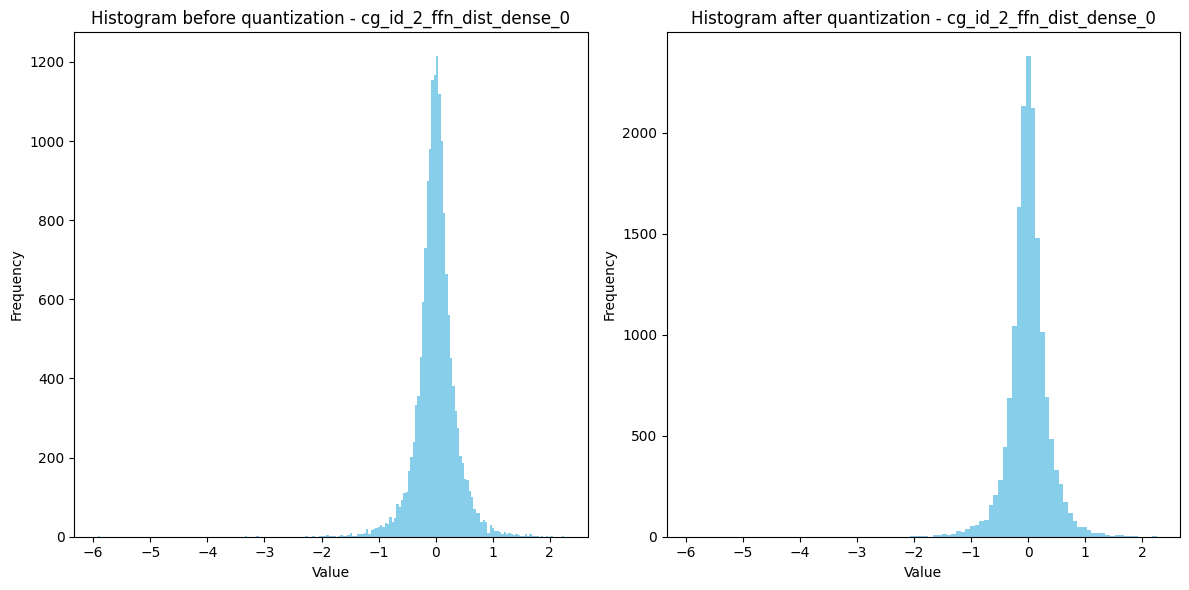

Output with Float 16 Quantization
Subgroup Name: cg_id_2_ffn_dist_dense_0
Original Bias Size: 368 bytes
Original Kernel Size: 65664 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 390.85714285714283x



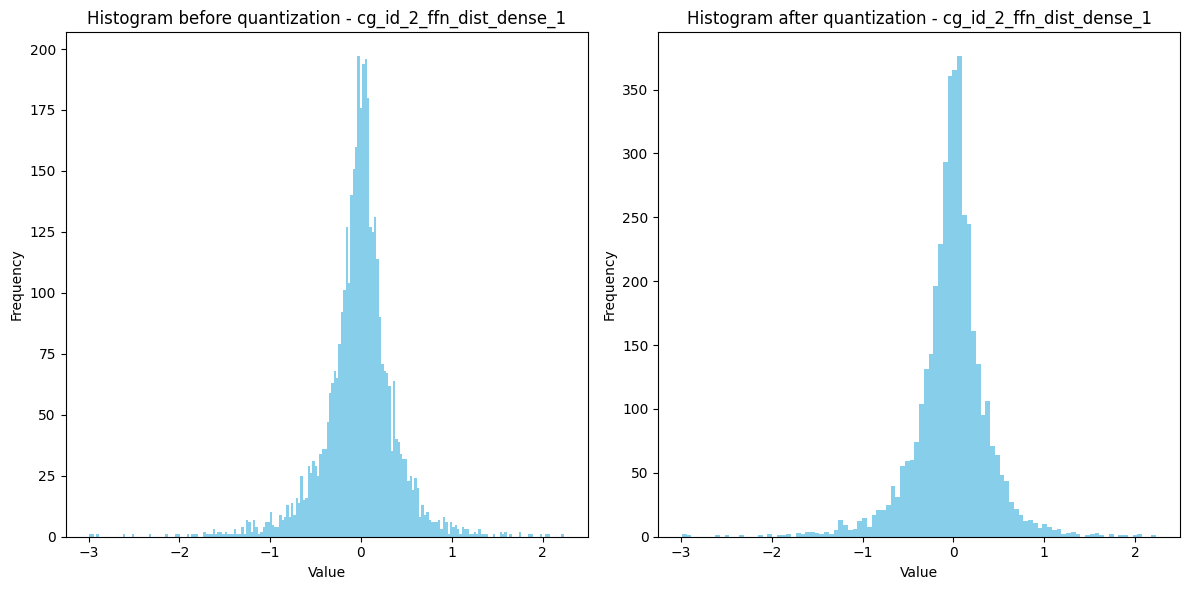

Output with Float 16 Quantization
Subgroup Name: cg_id_2_ffn_dist_dense_1
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 98.28571428571429x



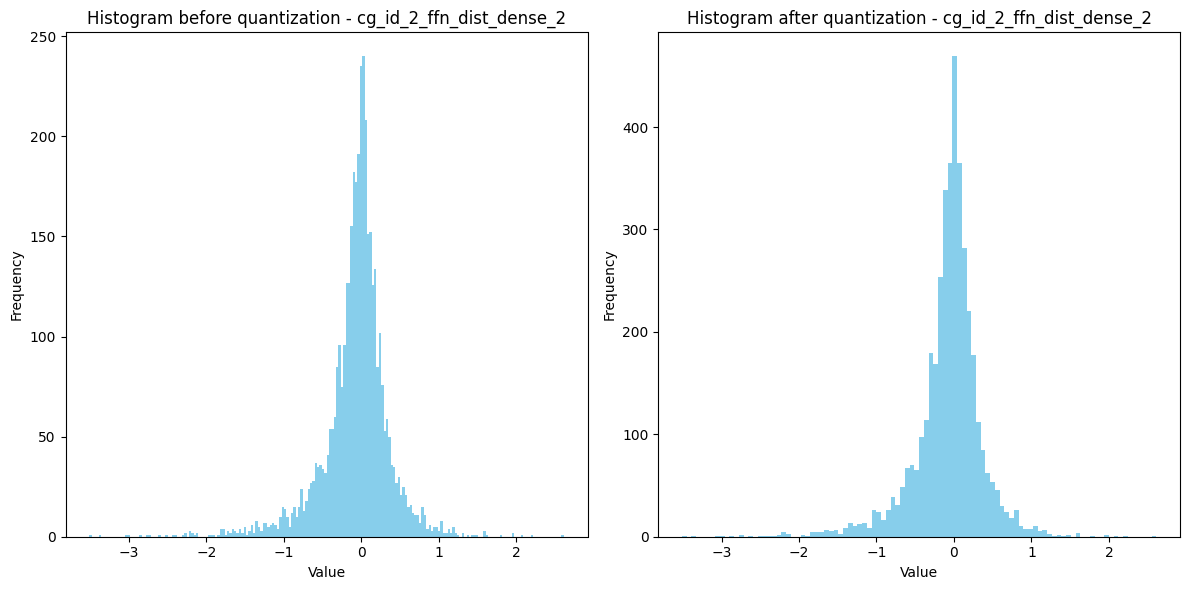

Output with Float 16 Quantization
Subgroup Name: cg_id_2_ffn_dist_dense_2
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 98.28571428571429x



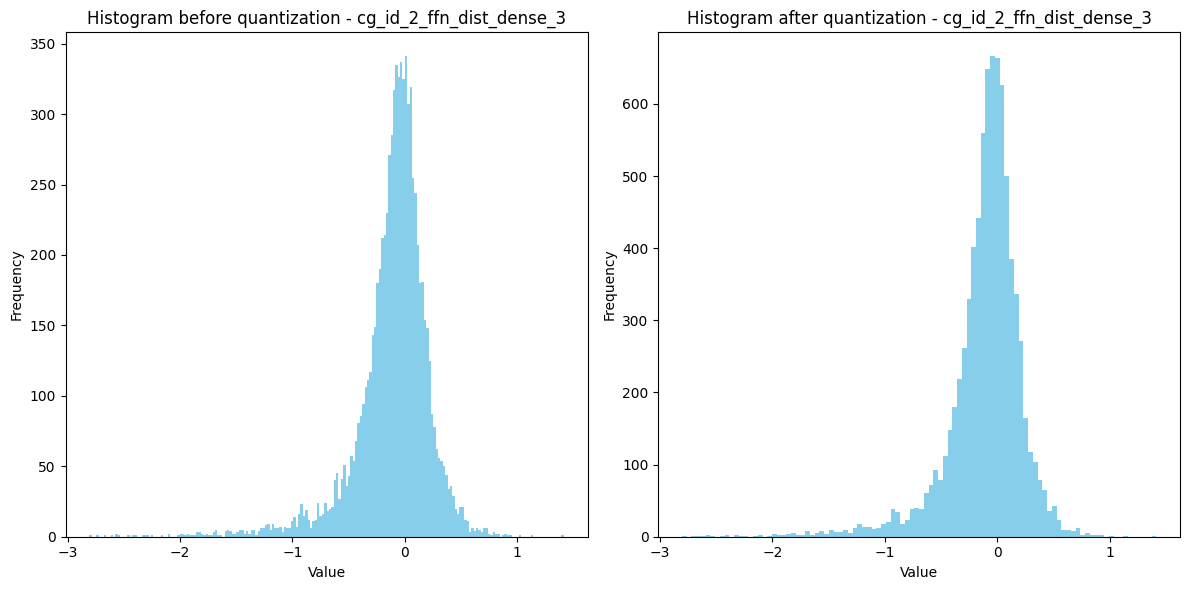

Output with Float 16 Quantization
Subgroup Name: cg_id_2_ffn_dist_dense_3
Original Bias Size: 624 bytes
Original Kernel Size: 32896 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 3.7142857142857144x
Reduction Factor for Kernel: 195.8095238095238x

Total Original Bias Size: 1728 bytes
Total Original Kernel Size: 131584 bytes
Total Quantized Bias Size: 672 bytes
Total Quantized Kernel Size: 672 bytes
Total Original Size: 133312 bytes
Total Quantized Size: 1344 bytes
Reduction Factor: 99.19047619047619x


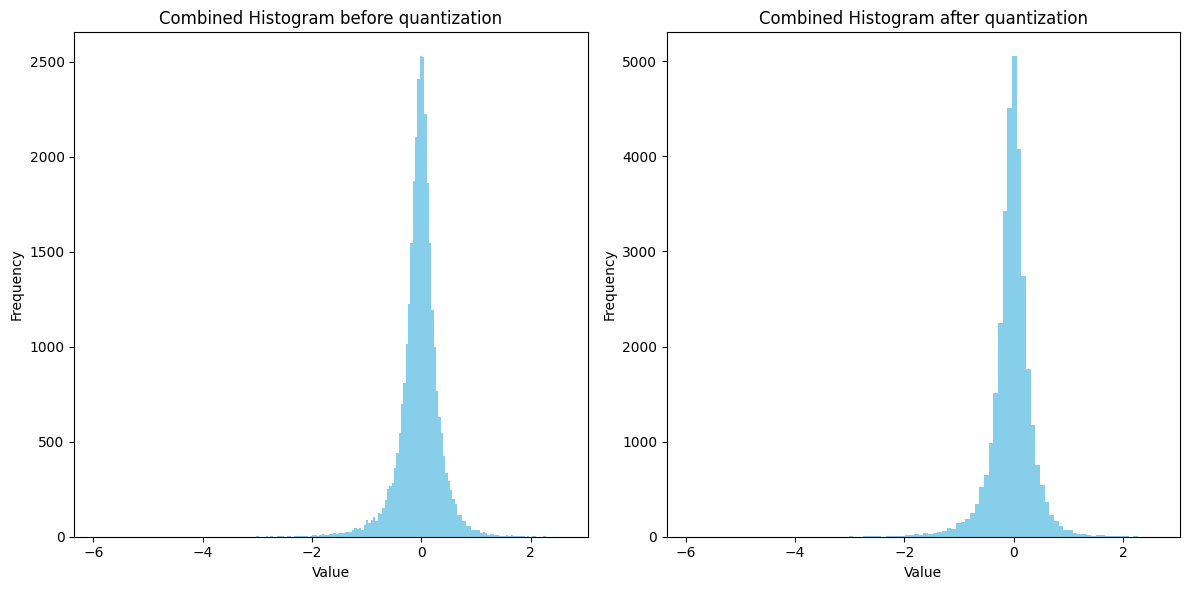

In [5]:
import h5py
import tensorflow as tf
import sys
import numpy as np
import matplotlib.pyplot as plt

# Define a function to apply Float16 quantization
def float16_quantization(weights):
    return tf.dtypes.cast(weights, tf.float16)

# Define a function to get the size of an object in bytes
def get_size(obj):
    return sys.getsizeof(obj)

total_original_bias_size = 0
total_original_kernel_size = 0
total_quantized_bias_size = 0
total_quantized_kernel_size = 0

all_original_kernel_values = []
all_quantized_kernel_values = []

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the group 'cg_id_0'
    group_cg_id_2 = file['cg_id_2']
    
    # Define a list of subgroup names
    subgroup_names = ['cg_id_2_ffn_dist_dense_0', 
                      'cg_id_2_ffn_dist_dense_1', 
                      'cg_id_2_ffn_dist_dense_2', 
                      'cg_id_2_ffn_dist_dense_3']
    
    for subgroup_name in subgroup_names:
        # Access the subgroup
        subgroup = group_cg_id_2[subgroup_name]
        
        # Load the weights (bias and kernel)
        bias = subgroup['bias:0'][()]  # Load bias
        kernel = subgroup['kernel:0'][()]  # Load kernel

        # Apply Float16 quantization to the weights
        float16_bias = float16_quantization(bias)
        float16_kernel = float16_quantization(kernel)

        # Print the sizes and reduction factors
        original_bias_size = get_size(bias)
        original_kernel_size = get_size(kernel)
        quantized_bias_size = get_size(float16_bias)
        quantized_kernel_size = get_size(float16_kernel)

        # Accumulate the sizes
        total_original_bias_size += original_bias_size
        total_original_kernel_size += original_kernel_size
        total_quantized_bias_size += quantized_bias_size
        total_quantized_kernel_size += quantized_kernel_size

        # Plot the histograms
        plt.figure(figsize=(12, 6))
        
        # Before quantization
        plt.subplot(1, 2, 1)
        plt.hist(kernel.flatten(), bins=200, color='skyblue')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram before quantization - {subgroup_name}')
        
        # After quantization
        plt.subplot(1, 2, 2)
        float16_kernel_array_proto = tf.make_tensor_proto(float16_kernel)
        float16_kernel_array = tf.make_ndarray(float16_kernel_array_proto)
        plt.hist(float16_kernel_array.flatten(), bins=100, color='skyblue')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram after quantization - {subgroup_name}')
        
        plt.tight_layout()
        plt.show()
        
        # Store kernel values for final combined plot
        all_original_kernel_values.extend(kernel.flatten())
        all_quantized_kernel_values.extend(float16_kernel_array.flatten())
        
        print(f"Output with Float 16 Quantization")
        print(f"=====================================")
        print(f"Subgroup Name: {subgroup_name}")
        print(f"Original Bias Size: {original_bias_size} bytes")
        print(f"Original Kernel Size: {original_kernel_size} bytes")
        print(f"Quantized Bias Size: {quantized_bias_size} bytes")
        print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")
        print(f"Reduction Factor for Bias: {original_bias_size / quantized_bias_size}x")
        print(f"Reduction Factor for Kernel: {original_kernel_size / quantized_kernel_size}x")
        print('======================')
        print()

# Calculate total sizes
total_original_size = total_original_bias_size + total_original_kernel_size
total_quantized_size = total_quantized_bias_size + total_quantized_kernel_size

# Print the total sizes and reduction factor
print(f"Total Original Bias Size: {total_original_bias_size} bytes")
print(f"Total Original Kernel Size: {total_original_kernel_size} bytes")
print(f"Total Quantized Bias Size: {total_quantized_bias_size} bytes")
print(f"Total Quantized Kernel Size: {total_quantized_kernel_size} bytes")
print(f"Total Original Size: {total_original_size} bytes")
print(f"Total Quantized Size: {total_quantized_size} bytes")
print(f"Reduction Factor: {total_original_size / total_quantized_size}x")

# Plot the final combined histograms
plt.figure(figsize=(12, 6))

# Before quantization
plt.subplot(1, 2, 1)
plt.hist(all_original_kernel_values, bins=200, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Combined Histogram before quantization')

# After quantization
plt.subplot(1, 2, 2)
plt.hist(all_quantized_kernel_values, bins=100, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Combined Histogram after quantization')

plt.tight_layout()
plt.show()


## int8 Quantization

Instructions for updating:
`tf.quantize_v2` is deprecated, please use `tf.quantization.quantize` instead.


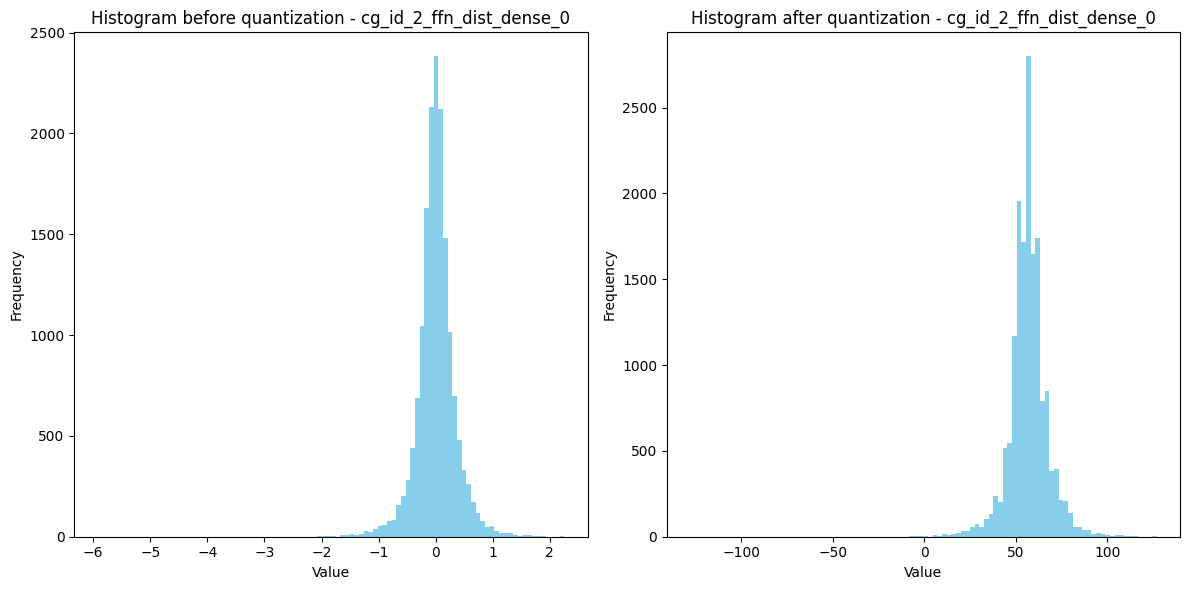

Output with Float 16 Quantization
Subgroup Name: cg_id_2_ffn_dist_dense_0
Original Bias Size: 368 bytes
Original Kernel Size: 65664 bytes
Quantized Bias Size: 64 bytes
Quantized Kernel Size: 64 bytes
Reduction Factor for Bias: 5.75x
Reduction Factor for Kernel: 1026.0x



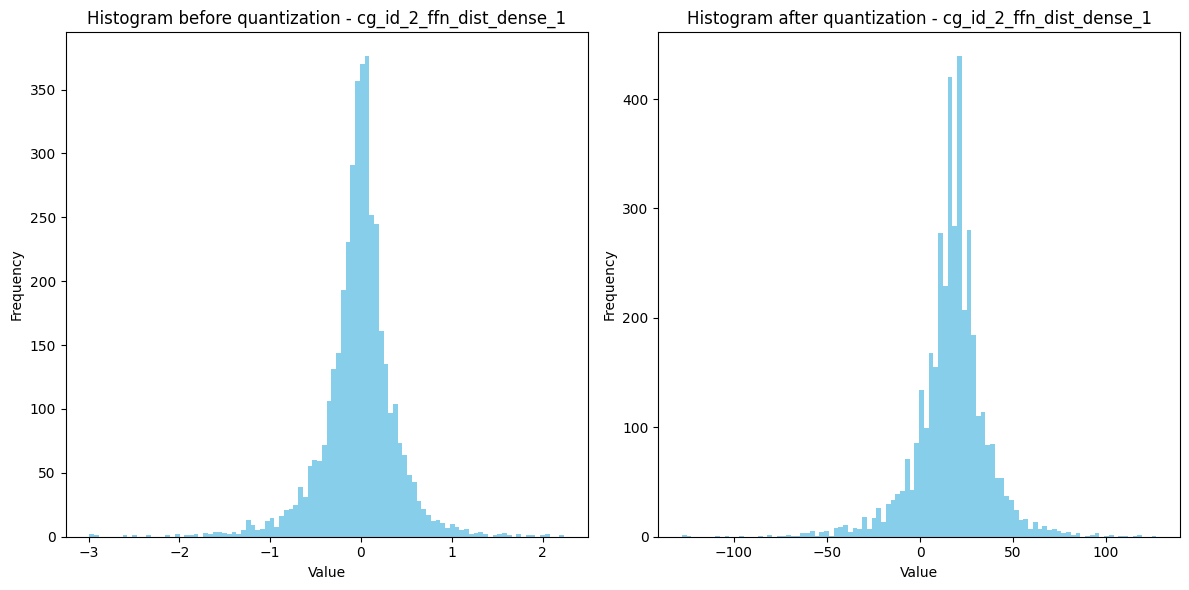

Output with Float 16 Quantization
Subgroup Name: cg_id_2_ffn_dist_dense_1
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 64 bytes
Quantized Kernel Size: 64 bytes
Reduction Factor for Bias: 5.75x
Reduction Factor for Kernel: 258.0x



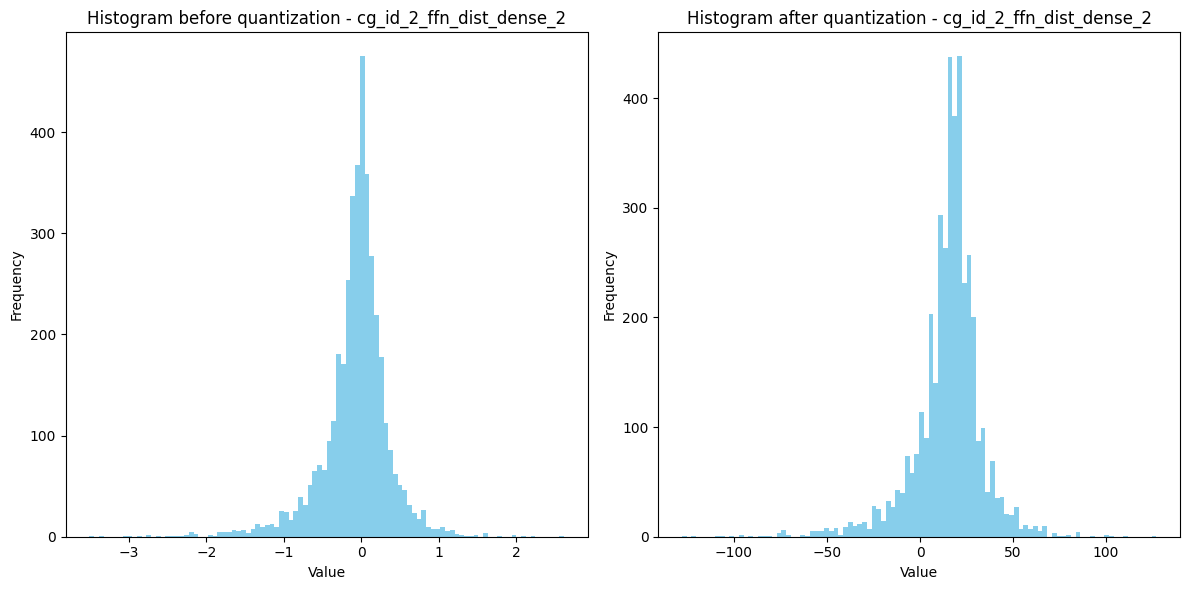

Output with Float 16 Quantization
Subgroup Name: cg_id_2_ffn_dist_dense_2
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 64 bytes
Quantized Kernel Size: 64 bytes
Reduction Factor for Bias: 5.75x
Reduction Factor for Kernel: 258.0x



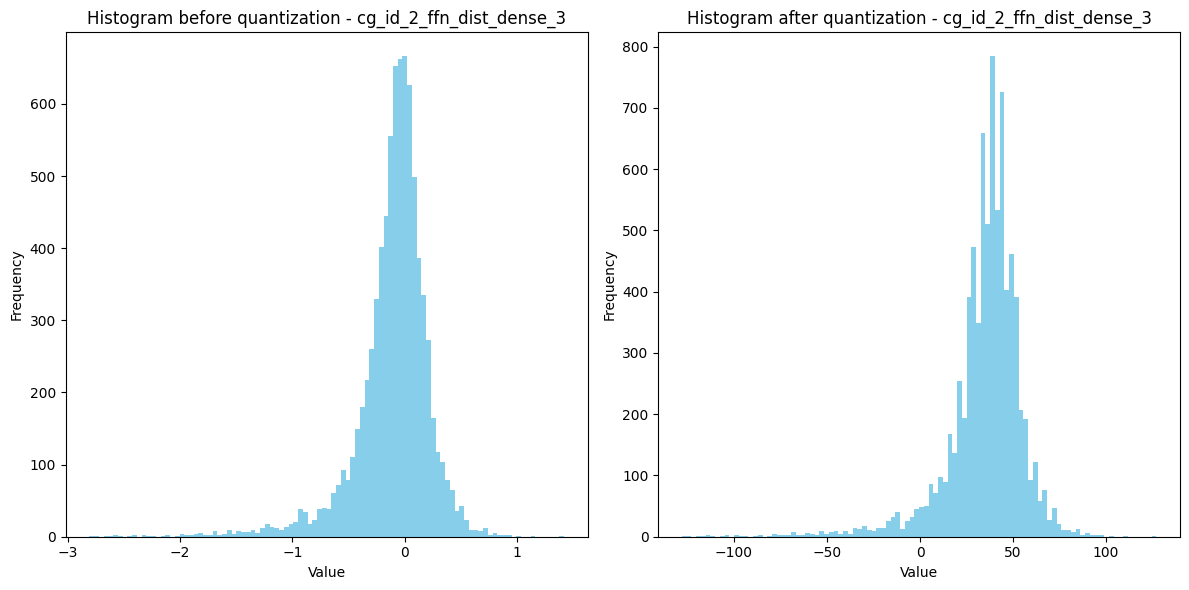

Output with Float 16 Quantization
Subgroup Name: cg_id_2_ffn_dist_dense_3
Original Bias Size: 624 bytes
Original Kernel Size: 32896 bytes
Quantized Bias Size: 64 bytes
Quantized Kernel Size: 64 bytes
Reduction Factor for Bias: 9.75x
Reduction Factor for Kernel: 514.0x

Total Original Bias Size: 1728 bytes
Total Original Kernel Size: 131584 bytes
Total Quantized Bias Size: 256 bytes
Total Quantized Kernel Size: 256 bytes
Total Original Size: 133312 bytes
Total Quantized Size: 512 bytes
Reduction Factor: 260.375x


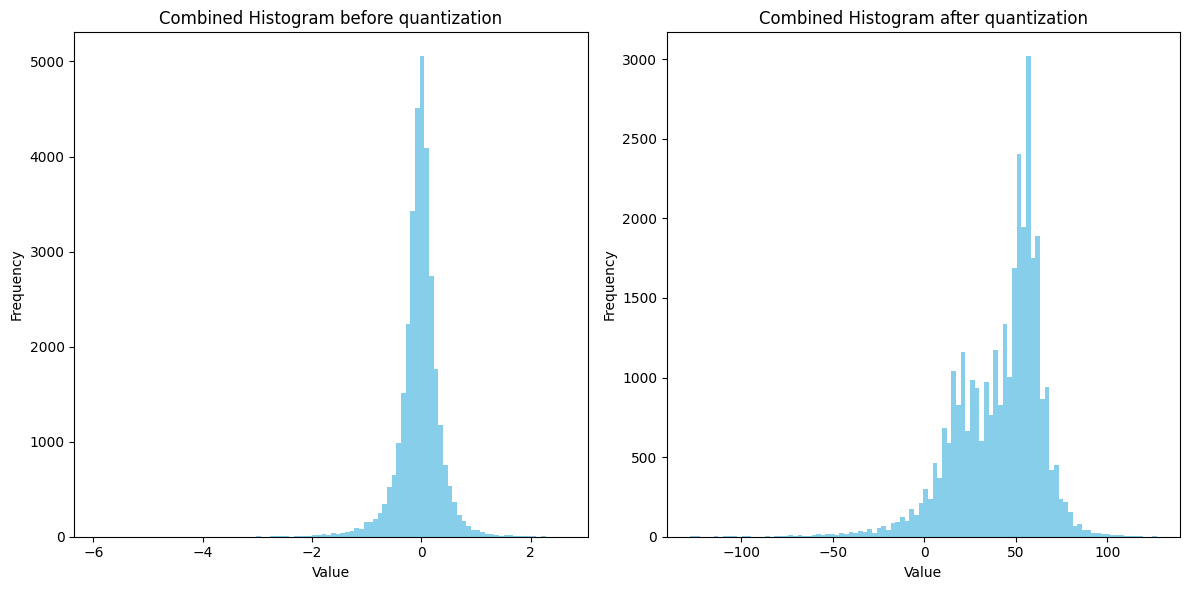

In [6]:
import h5py
import tensorflow as tf
import sys
import numpy as np
import matplotlib.pyplot as plt

# Define a function to apply Int8 quantization
def int8_quantization(weights):
    min_val = tf.reduce_min(weights)
    max_val = tf.reduce_max(weights)
    quantized_weights = tf.quantization.quantize(weights, min_val, max_val, tf.qint8)
    return quantized_weights


# Define a function to get the size of an object in bytes
def get_size(obj):
    return sys.getsizeof(obj)

total_original_bias_size = 0
total_original_kernel_size = 0
total_quantized_bias_size = 0
total_quantized_kernel_size = 0

all_original_kernel_values = []
all_quantized_kernel_values = []

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the group 'cg_id_0'
    group_cg_id_2 = file['cg_id_2']
    
    # Define a list of subgroup names
    subgroup_names = ['cg_id_2_ffn_dist_dense_0', 
                      'cg_id_2_ffn_dist_dense_1', 
                      'cg_id_2_ffn_dist_dense_2', 
                      'cg_id_2_ffn_dist_dense_3']
    
    for subgroup_name in subgroup_names:
        # Access the subgroup
        subgroup = group_cg_id_2[subgroup_name]
        
        # Load the weights (bias and kernel)
        bias = subgroup['bias:0'][()]  # Load bias
        kernel = subgroup['kernel:0'][()]  # Load kernel

        # Apply Float16 quantization to the weights
        float16_bias = int8_quantization(bias)
        float16_kernel = int8_quantization(kernel)

        # Print the sizes and reduction factors
        original_bias_size = get_size(bias)
        original_kernel_size = get_size(kernel)
        quantized_bias_size = get_size(float16_bias)
        quantized_kernel_size = get_size(float16_kernel)

        # Accumulate the sizes
        total_original_bias_size += original_bias_size
        total_original_kernel_size += original_kernel_size
        total_quantized_bias_size += quantized_bias_size
        total_quantized_kernel_size += quantized_kernel_size

        # Plot the histograms
        plt.figure(figsize=(12, 6))
        
        # Before quantization
        plt.subplot(1, 2, 1)
        plt.hist(kernel.flatten(), bins=100, color='skyblue')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram before quantization - {subgroup_name}')
        
        # After quantization
        plt.subplot(1, 2, 2)
        float16_kernel_array_proto = tf.make_tensor_proto(float16_kernel[0])
        float16_kernel_array = tf.make_ndarray(float16_kernel_array_proto)
        plt.hist(float16_kernel_array.flatten(), bins=100, color='skyblue')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram after quantization - {subgroup_name}')
        
        plt.tight_layout()
        plt.show()
        
        # Store kernel values for final combined plot
        all_original_kernel_values.extend(kernel.flatten())
        all_quantized_kernel_values.extend(float16_kernel_array.flatten())
        
        print(f"Output with Float 16 Quantization")
        print(f"=====================================")
        print(f"Subgroup Name: {subgroup_name}")
        print(f"Original Bias Size: {original_bias_size} bytes")
        print(f"Original Kernel Size: {original_kernel_size} bytes")
        print(f"Quantized Bias Size: {quantized_bias_size} bytes")
        print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")
        print(f"Reduction Factor for Bias: {original_bias_size / quantized_bias_size}x")
        print(f"Reduction Factor for Kernel: {original_kernel_size / quantized_kernel_size}x")
        print('======================')
        print()

# Calculate total sizes
total_original_size = total_original_bias_size + total_original_kernel_size
total_quantized_size = total_quantized_bias_size + total_quantized_kernel_size

# Print the total sizes and reduction factor
print(f"Total Original Bias Size: {total_original_bias_size} bytes")
print(f"Total Original Kernel Size: {total_original_kernel_size} bytes")
print(f"Total Quantized Bias Size: {total_quantized_bias_size} bytes")
print(f"Total Quantized Kernel Size: {total_quantized_kernel_size} bytes")
print(f"Total Original Size: {total_original_size} bytes")
print(f"Total Quantized Size: {total_quantized_size} bytes")
print(f"Reduction Factor: {total_original_size / total_quantized_size}x")

# Plot the final combined histograms
plt.figure(figsize=(12, 6))

# Before quantization
plt.subplot(1, 2, 1)
plt.hist(all_original_kernel_values, bins=100, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Combined Histogram before quantization')

# After quantization
plt.subplot(1, 2, 2)
plt.hist(all_quantized_kernel_values, bins=100, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Combined Histogram after quantization')

plt.tight_layout()
plt.show()
